In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')


In [12]:
# Load data
Path_Data = '3_merged_data3.txt'
df = pd.read_csv(Path_Data, sep='\t')

In [13]:
# Prepare data
X = df.drop(columns=['ID', 'avg7_calingiri'])
y = df['avg7_calingiri']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (119, 33048)
Shape of X_test: (30, 33048)


In [14]:
# --- GA Parameters ---
population_size = 50
mutation_rate = 0.1
num_generations = 10
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Initialize population (only feature bits now) ---
def initialize_population():
    np.random.seed(42)
    population = []
    for _ in range(population_size):
        features = np.random.randint(2, size=X_train.shape[1])
        population.append(features)
    return population

# --- Decode individual (only feature bits) ---
def decode_individual(individual):
    feature_bits = individual.astype(int)
    return feature_bits

# --- Fitness function ---
def fitness_function(individual):
    features = decode_individual(individual)
    selected_cols = [i for i, bit in enumerate(features) if bit == 1]
    if len(selected_cols) == 0:
        return np.inf

    model = LinearRegression()
    X_selected = X_train.iloc[:, selected_cols]
    scores = -1 * cross_val_score(model, X_selected, y_train, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
    return scores.mean()


In [15]:
# --- Selection (Tournament) ---
def selection(population, scores):
    selected = []
    for _ in range(len(population)):
        i1, i2 = random.sample(range(len(population)), 2)
        selected.append(population[i1] if scores[i1] < scores[i2] else population[i2])
    return selected

# --- Crossover ---
def crossover(p1, p2):
    split_point = random.randint(1, len(p1) - 1)
    child1 = np.concatenate((p1[:split_point], p2[split_point:]))
    child2 = np.concatenate((p2[:split_point], p1[split_point:]))
    return child1, child2

# --- Mutation ---
def mutate(individual):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = 1 - individual[i]
    return individual


In [16]:
# --- Run GA ---
population = initialize_population()
history = []

for gen in tqdm(range(num_generations), desc="GA Generations"):
    scores = [fitness_function(ind) for ind in population]
    history.append(min(scores))

    # Elitism: top 50%
    sorted_pop = [x for _, x in sorted(zip(scores, population), key=lambda pair: pair[0])]
    population = sorted_pop[:population_size//2]

    next_gen = population.copy()
    while len(next_gen) < population_size:
        p1, p2 = random.sample(population, 2)
        c1, c2 = crossover(p1, p2)
        next_gen.append(mutate(c1))
        if len(next_gen) < population_size:
            next_gen.append(mutate(c2))

    population = next_gen

# --- Best individual ---
best_individual = sorted(population, key=fitness_function)[0]
best_features = decode_individual(best_individual)

print(f"\nSelected Features: {X.columns[best_features == 1].tolist()}")

GA Generations: 100%|██████████| 10/10 [12:59<00:00, 77.95s/it]



Selected Features: ['SNOO_500610_1', 'SNOO_500610_2', 'SNOO_104700A_1', 'SNOO_104700A_2', 'SNOO_129020A_2', 'SNOO_158180A_1', 'SNOO_158180A_2', 'SNOO_447800A_1', 'SNOO_506430_1', 'SNOO_558880_1', 'SNOO_308090A_1', 'SNOO_012890A_1', 'SNOO_143640A_1', 'SNOO_132970A_1', 'SNOO_426170A_1', 'SNOO_426170A_2', 'SNOO_426170A_3', 'SNOO_014170A_1', 'SNOO_564790_1', 'SNOO_564790_2', 'SNOO_027500A_1', 'SNOO_553590_1', 'SNOO_417830A_1', 'SNOO_522570_1', 'SNOO_597830_1', 'SNOO_158960A_1', 'SNOO_158960A_2', 'SNOO_611660_1', 'SNOO_303110A_2', 'SNOO_130830A_3', 'SNOO_043300A_1', 'SNOO_043300A_2', 'SNOO_519540_2', 'SNOO_082060A_1', 'SNOO_628390_1', 'SNOO_628390_2', 'SNOO_618210_1', 'SNOO_162030A_1', 'SNOO_162030A_3', 'SNOO_020890A_3', 'SNOO_020730A_1', 'SNOO_509940_1', 'SNOO_427870A_1', 'SNOO_407830A_1', 'SNOO_031540A_1', 'SNOO_433520A_1', 'SNOO_419710A_2', 'SNOO_149370A_1', 'SNOO_041130A_1', 'SNOO_446660A_1', 'SNOO_446660A_2', 'SNOO_510360_1', 'SNOO_510360_2', 'SNOO_140000A_1', 'SNOO_140000A_2', 'SNOO_

In [17]:
# --- Train best model ---
lr_best = LinearRegression()
X_train_sel = X_train.iloc[:, best_features == 1]
X_test_sel = X_test.iloc[:, best_features == 1]

lr_best.fit(X_train_sel, y_train)
y_pred_test = lr_best.predict(X_test_sel)

mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("\n🔍 Final Evaluation on Test Set")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")


🔍 Final Evaluation on Test Set
MSE: 1.5652
MAE: 1.0230
R2: -0.1361


In [18]:
# --- Save model and features ---
pickle.dump(lr_best, open("GA_LR_Model.pkl", "wb"))

selected_feature_indices = np.where(best_features == 1)[0]
selected_feature_names = X.columns[selected_feature_indices].tolist()

pickle.dump(selected_feature_indices, open("GA_Selected_Feature_Indices.pkl", "wb"))
pickle.dump(selected_feature_names, open("GA_Selected_Feature_Names.pkl", "wb"))

pd.Series(selected_feature_names, name="Selected_Features").to_csv("GA_Selected_Features.csv", index=False)

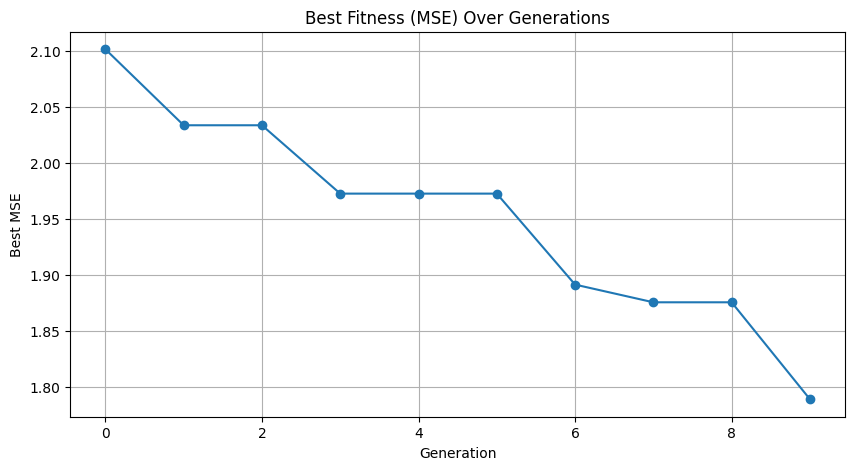

In [19]:
# --- Plot fitness history ---
plt.figure(figsize=(10, 5))
plt.plot(history, marker='o')
plt.title("Best Fitness (MSE) Over Generations")
plt.xlabel("Generation")
plt.ylabel("Best MSE")
plt.grid(True)
plt.show()

In [20]:
# --- Train full model for comparison ---
model_full = LinearRegression()
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict(X_test)

mse_full = mean_squared_error(y_test, y_pred_full)
mae_full = mean_absolute_error(y_test, y_pred_full)
r2_full = r2_score(y_test, y_pred_full)

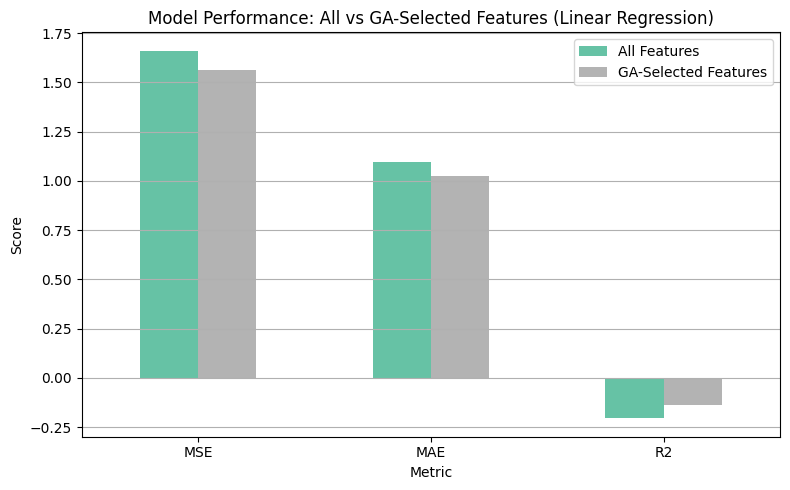

In [21]:
# --- Compare metrics visually ---
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2'],
    'All Features': [mse_full, mae_full, r2_full],
    'GA-Selected Features': [mse, mae, r2]
})

metrics_df.set_index('Metric').plot(kind='bar', figsize=(8, 5), colormap='Set2')
plt.title("Model Performance: All vs GA-Selected Features (Linear Regression)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

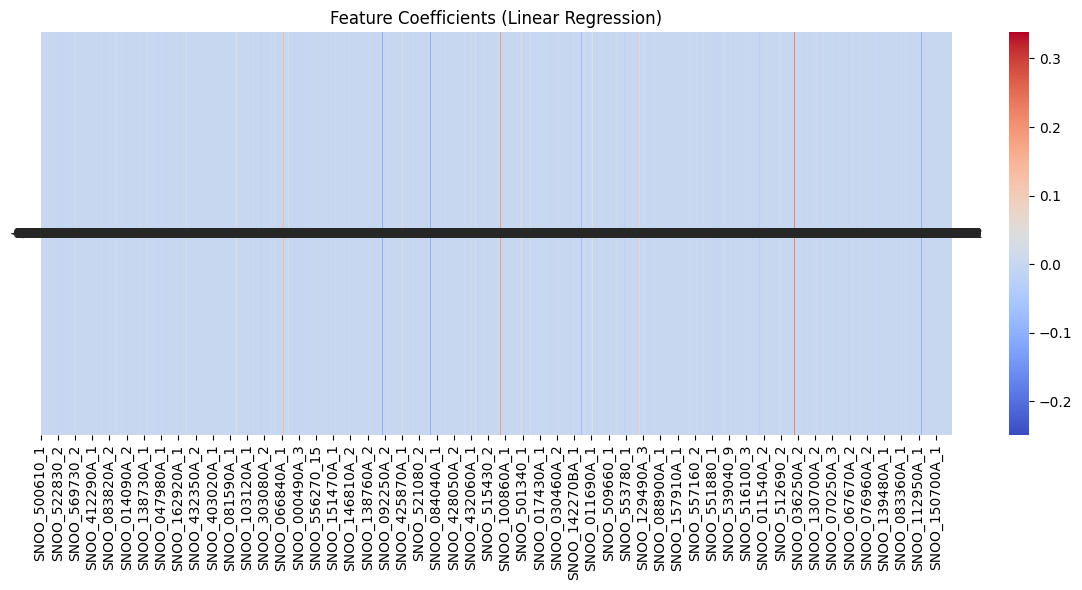

In [22]:
# --- Feature coefficients heatmap ---
plt.figure(figsize=(12, 6))
coefs = lr_best.coef_.reshape(1, -1)
sns.heatmap(pd.DataFrame(coefs, columns=X_train_sel.columns), cmap='coolwarm', annot=True)
plt.title("Feature Coefficients (Linear Regression)")
plt.tight_layout()
plt.show()